In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns

In [2]:
data = pd.read_csv("./data/heart.csv")

In [3]:
data.shape

(1025, 14)

In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
healthy_or_not = data['target'].value_counts().to_list()
print(healthy_or_not)

[526, 499]


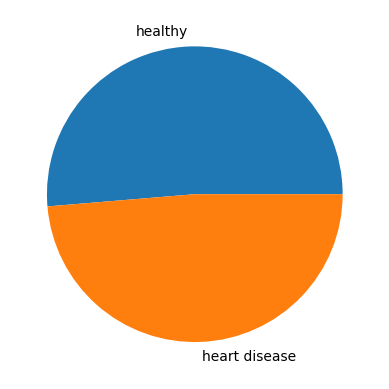

In [6]:
plt.pie(healthy_or_not, labels=['healthy', 'heart disease'])
plt.show()

In [7]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

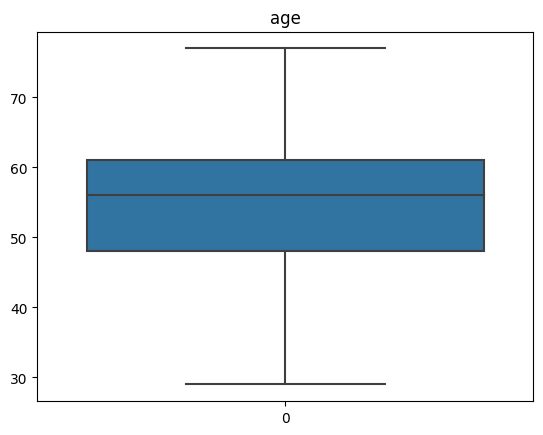

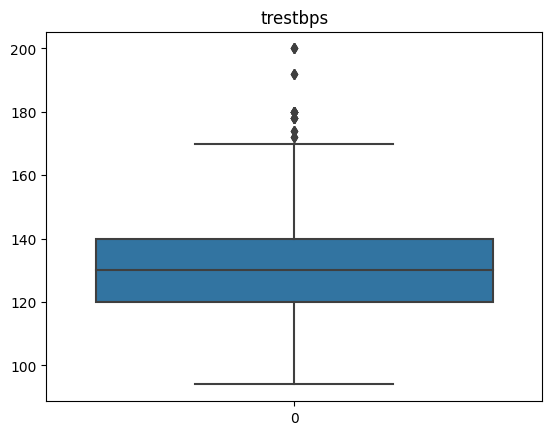

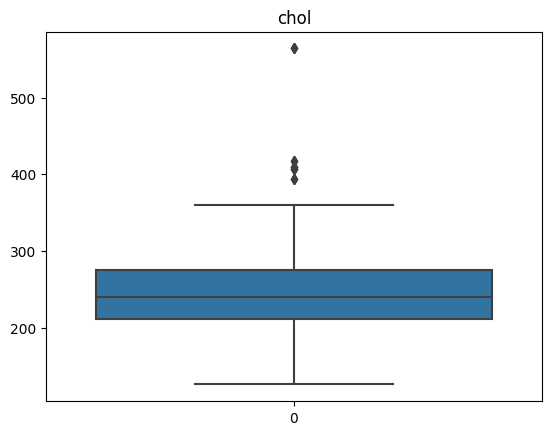

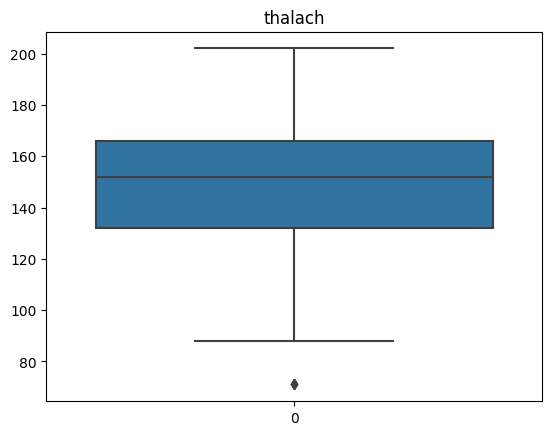

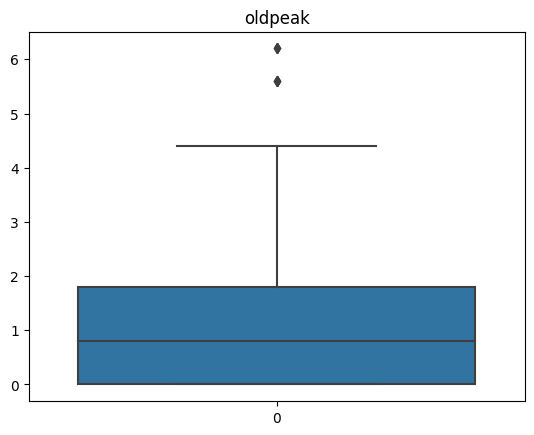

In [9]:
for col in numerical_columns:
    if col != 'target':
        sns.boxplot(data=data[col])
        plt.title(col)
        plt.show()

In [10]:
from collections import Counter
def iqr_method(df, n, features):
    outlier_list = []
    for col in features:
        q1 = np.percentile(df[col], 25)
        q3 = np.percentile(df[col], 75)
        iqr = q3 - q1

        max_limit = q3 + (1.5 * iqr)
        min_limit = q1 - (1.5 * iqr)

        outlier_column_list = df[(df[col] < min_limit) | (df[col] > max_limit)].index
        outlier_list.extend(outlier_column_list)

    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    df1 = df[df[col] < min_limit]
    df2 = df[df[col] > max_limit]
    
    print('Total number of outliers is:', df1.shape[0]+df2.shape[0])
    
    return multiple_outliers

In [11]:
outliers = iqr_method(data, 1, numerical_columns)
data = data.drop(outliers, axis=0).reset_index(drop=True)

Total number of outliers is: 7


In [12]:
df = pd.get_dummies(data, drop_first=True)

In [13]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [14]:
x = df.drop('target', axis=1)
y = df['target']

In [15]:
x.shape, y.shape

((1025, 13), (1025,))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size = 0.3, random_state = 42)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((717, 13), (717,), (308, 13), (308,))

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
numerical_columns

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [20]:
scaler = StandardScaler().fit(X_train[numerical_columns].values)

In [21]:
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns].values)
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns].values)

In [22]:
X_train.shape

(717, 13)

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten

In [24]:
model = Sequential([
    tensorflow.keras.Input(shape=(13)),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(8, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(4, activation='relu', kernel_initializer='he_normal'),
    Dense(2, activation='softmax', kernel_initializer='he_normal')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

In [26]:
model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics=["accuracy", tensorflow.keras.metrics.AUC()])

In [27]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [28]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=50, batch_size=32, verbose=1)

Epoch 1/50
23/23 [==============================] - 2s 22ms/step - loss: 0.7247 - accuracy: 0.6109 - auc: 0.6299 - val_loss: 0.6941 - val_accuracy: 0.5032 - val_auc: 0.5012
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.6405 - accuracy: 0.7476 - auc: 0.7957 - val_loss: 0.6777 - val_accuracy: 0.6688 - val_auc: 0.6821
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.5747 - accuracy: 0.8215 - auc: 0.8883 - val_loss: 0.6245 - val_accuracy: 0.7760 - val_auc: 0.8016
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.5222 - accuracy: 0.8480 - auc: 0.9272 - val_loss: 0.5898 - val_accuracy: 0.7630 - val_auc: 0.8218
Epoch 5/50
23/23 [==============================] - 0s 8ms/step - loss: 0.4740 - accuracy: 0.8870 - auc: 0.9493 - val_loss: 0.5410 - val_accuracy: 0.8182 - val_auc: 0.8610
Epoch 6/50
23/23 [==============================] - 0s 6ms/step - loss: 0.4345 - accuracy: 0.8898 - auc: 0.9516 - val_loss: 0.4636 - val_ac

In [29]:
model.predict(X_test)

10/10 [==============================] - 0s 3ms/step


array([[9.99988794e-01, 1.12428907e-05],
       [9.99995112e-01, 4.91299761e-06],
       [3.42648673e-05, 9.99965787e-01],
       [1.40025641e-05, 9.99986053e-01],
       [2.59214858e-06, 9.99997377e-01],
       [5.38348104e-05, 9.99946117e-01],
       [9.99995112e-01, 4.92289382e-06],
       [4.44581474e-07, 9.99999523e-01],
       [9.99971986e-01, 2.80535314e-05],
       [5.88212628e-04, 9.99411821e-01],
       [8.70605509e-05, 9.99912977e-01],
       [5.54041564e-01, 4.45958495e-01],
       [9.99983788e-01, 1.62429114e-05],
       [9.32164403e-06, 9.99990702e-01],
       [1.18725731e-08, 1.00000000e+00],
       [9.99995112e-01, 4.91299761e-06],
       [2.03084301e-06, 9.99997973e-01],
       [9.99997139e-01, 2.81273060e-06],
       [1.38937148e-05, 9.99986053e-01],
       [9.99991417e-01, 8.58305248e-06],
       [1.02026370e-05, 9.99989748e-01],
       [3.85889098e-06, 9.99996185e-01],
       [6.44510521e-07, 9.99999404e-01],
       [6.19820923e-08, 9.99999881e-01],
       [1.986399

In [30]:
import os.path
if os.path.isfile('models/heart1.h5') is False:
    model.save('models/heart1.h5')

In [31]:
history.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x21b1be07c70>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7246574759483337,
   0.6404757499694824,
   0.5747401714324951,
   0.5221696496009827,
   0.47396644949913025,
   0.43453121185302734,
   0.38151830434799194,
   0.3458455204963684,
   0.30114540457725525,
   0.2736915647983551,
   0.24246330559253693,
   0.1920914202928543,
   0.1683228611946106,
   0.14956769347190857,
   0.13052897155284882,
   0.1192018911242485,
   0.1040763407945633,
   0.0989299789071083,
   0.08104509860277176,
   0.06895086914300919,
   0.060537826269865036,
   0.08493804931640625,
   0.06800247728824615,
   0.057079561054706573,
   0.06425146013498306,
   0.04493352770805359,
   0.07548554986715317,
   0.06148581579327583,
   0.07455835491418839,
   0.05411906912922859,
   0.0534212589263916,
   0.034778133034706116,
   0.03623117879033089,
   0.06291411072015762,
   0.04720726236701012,
 

[]

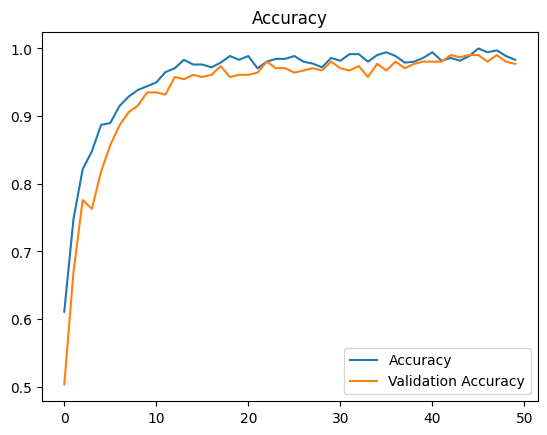

In [32]:
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.plot()

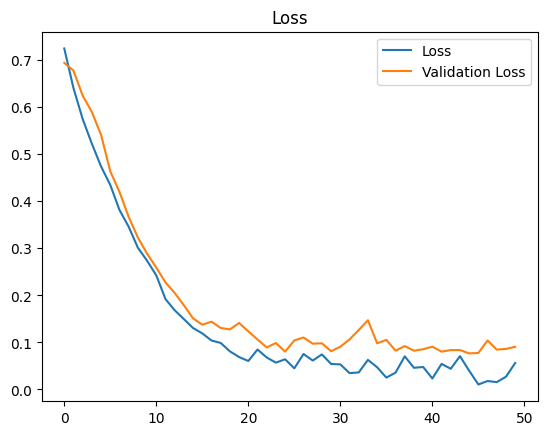

In [33]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.show()